<strong>Project Title</strong>
AI for Predicting Glacial Lake Outburst Floods

<strong>Project Statement:</strong>
Accelerating glacier melt caused by rising temperatures is increasing the size of glacial lakes behind unstable natural dams. This change raises the chances of sudden, high-volume outburst floods. These floods can release millions of cubic meters of water without warning, putting downstream villages, infrastructure, and ecosystems at risk. Traditional monitoring methods, which often depend on infrequent field surveys and low-resolution images, do not offer the multi-day advance notice required for timely evacuations and disaster response.

<strong>Project Description:</strong>
This dataset is a detailed account of each lake and glacier moment: when and where it happened (date, latitude/longitude, elevation), how the lake looks (area, volume, dam type/geometry), what the mountains feel like (slope, relief, drainage basin), how the glacier is changing (area, retreat, ice velocity), and what the sky and ground are doing (temperature anomaly, PDD, precipitation, seismic counts/magnitudes, distance to faults). These features provide early warnings by connecting recent climate changes to melt-driven inflows, seismic activity to dam weakening, and the land's shape to outburst pathways. Past events and the time since the last GLOF add context to the story. In practice, lake metrics indicate potential volume release, climate time series influence short-term risk, and seismic signals identify instability over the next week.

Importing Libraries

In [16]:
import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

Loading Data

In [2]:
df_raw = pd.read_csv('synthetic_glof_dataset.csv')

To display first 5 rows

In [3]:
print (df_raw.head())

   Event_ID  Year  Month  Day   Latitude  Longitude  Elevation_m  \
0         1  2018      9    7  32.236797  84.868270  3000.000000   
1         2  2004      8    9  23.930363  83.094716  3503.686693   
2         3  1997      2   17  39.719384  67.418070  4545.163067   
3         4  2010      9   11  21.885444  91.384509  4902.556371   
4         5  2008      7    7  33.978516  86.721841  3863.909151   

   Lake_Area_km2  Lake_Volume_MCM  Dam_Height_m  ...     Relief_m  \
0       0.093152         4.963821     79.124651  ...   406.249662   
1       1.435321         1.207065     48.923006  ...  1043.919966   
2       1.176976         0.460762     34.990785  ...  1131.364572   
3       0.888619         1.161838     56.175026  ...   683.912019   
4       0.221790         0.544109     88.419093  ...  1851.374498   

  Drainage_Basin_Area_km2  Previous_GLOF_Events  Years_Since_Last_GLOF  \
0             1260.075001                     1               7.657760   
1              140.486225   

Removing Duplicate Values

In [4]:
df_raw.info()
print (df_raw.describe())
print (df_raw.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 32 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Event_ID                         1000 non-null   int64  
 1   Year                             1000 non-null   int64  
 2   Month                            1000 non-null   int64  
 3   Day                              1000 non-null   int64  
 4   Latitude                         1000 non-null   float64
 5   Longitude                        1000 non-null   float64
 6   Elevation_m                      1000 non-null   float64
 7   Lake_Area_km2                    1000 non-null   float64
 8   Lake_Volume_MCM                  1000 non-null   float64
 9   Dam_Height_m                     1000 non-null   float64
 10  Dam_Width_m                      1000 non-null   float64
 11  Lake_Type                        1000 non-null   object 
 12  Temperature_Anomaly_C

In [5]:
print(f"\nMissing values before cleaning:\n{df_raw.isnull().sum()}")
df_raw = df_raw.dropna()


Missing values before cleaning:
Event_ID                           0
Year                               0
Month                              0
Day                                0
Latitude                           0
Longitude                          0
Elevation_m                        0
Lake_Area_km2                      0
Lake_Volume_MCM                    0
Dam_Height_m                       0
Dam_Width_m                        0
Lake_Type                          0
Temperature_Anomaly_C              0
Precipitation_mm                   0
PDD_Total                          0
Seismic_Activity_Count             0
Max_Earthquake_Magnitude           0
Distance_to_Fault_km               0
Glacier_Area_km2                   0
Glacier_Retreat_Rate_m_per_year    0
Ice_Velocity_m_per_year            0
Slope_Degree                       0
Relief_m                           0
Drainage_Basin_Area_km2            0
Previous_GLOF_Events               0
Years_Since_Last_GLOF              0
GLOF_

In [6]:
df_raw = df_raw.drop_duplicates()
print(f"Dataset shape after cleaning: {df_raw.shape}")

Dataset shape after cleaning: (1000, 32)


In [7]:
df_raw['Year'] = df_raw['Year'].astype(int)
df_raw['Month'] = df_raw['Month'].astype(int)
df_raw['Day'] = df_raw['Day'].astype(int)

In [9]:
df_raw['Date'] = pd.to_datetime(df_raw[['Year','Month','Day']])
df_raw['Days_Since_1990'] = (df_raw['Date'] - pd.to_datetime('1990-01-01')).dt.days
df_raw['Season'] = df_raw['Month'].map({
    12:'Winter',1:'Winter',2:'Winter',
    3:'Spring',4:'Spring',5:'Spring',
    6:'Summer',7:'Summer',8:'Summer',
    9:'Autumn',10:'Autumn',11:'Autumn'
    })

In [10]:
df_raw['High_Altitude_Risk'] = (df_raw['Elevation_m'] > 4500).astype(int)
df_raw['Large_Lake_Risk'] = (df_raw['Lake_Area_km2'] > df_raw['Lake_Area_km2'].quantile(0.8)).astype(int)
df_raw['High_Volume_Risk'] = (df_raw['Lake_Volume_MCM'] > df_raw['Lake_Volume_MCM'].quantile(0.8)).astype(int)
df_raw['Climate_Risk_Score'] = df_raw['Temperature_Anomaly_C'] * df_raw['PDD_Total'] / 1000
df_raw['Seismic_Risk_Score'] = df_raw['Max_Earthquake_Magnitude'] / (df_raw['Distance_to_Fault_km'] + 1)

In [11]:
le_lake_type = LabelEncoder()
le_season = LabelEncoder()
df_raw['Lake_Type_Encoded'] = le_lake_type.fit_transform(df_raw['Lake_Type'].astype(str))
df_raw['Season_Encoded'] = le_season.fit_transform(df_raw['Season'].astype(str))

In [26]:
joblib.dump(le_lake_type, 'lake_type_encoder.pkl')
joblib.dump(le_season, 'season_encoder.pkl')

['season_encoder.pkl']

In [12]:
drop_cols = ['Event_ID','Date','Years_Since_Last_GLOF','Elevation_Band', 'Lake_Type', 'Season']
df = df_raw.drop(columns=[c for c in drop_cols if c in df_raw.columns])

In [13]:
print(f"\nDataset shape after feature engineering: {df.shape}")


Dataset shape after feature engineering: (1000, 36)


In [14]:
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
print(f"Numerical columns for analysis: {len(numerical_cols)} features")

Numerical columns for analysis: 36 features


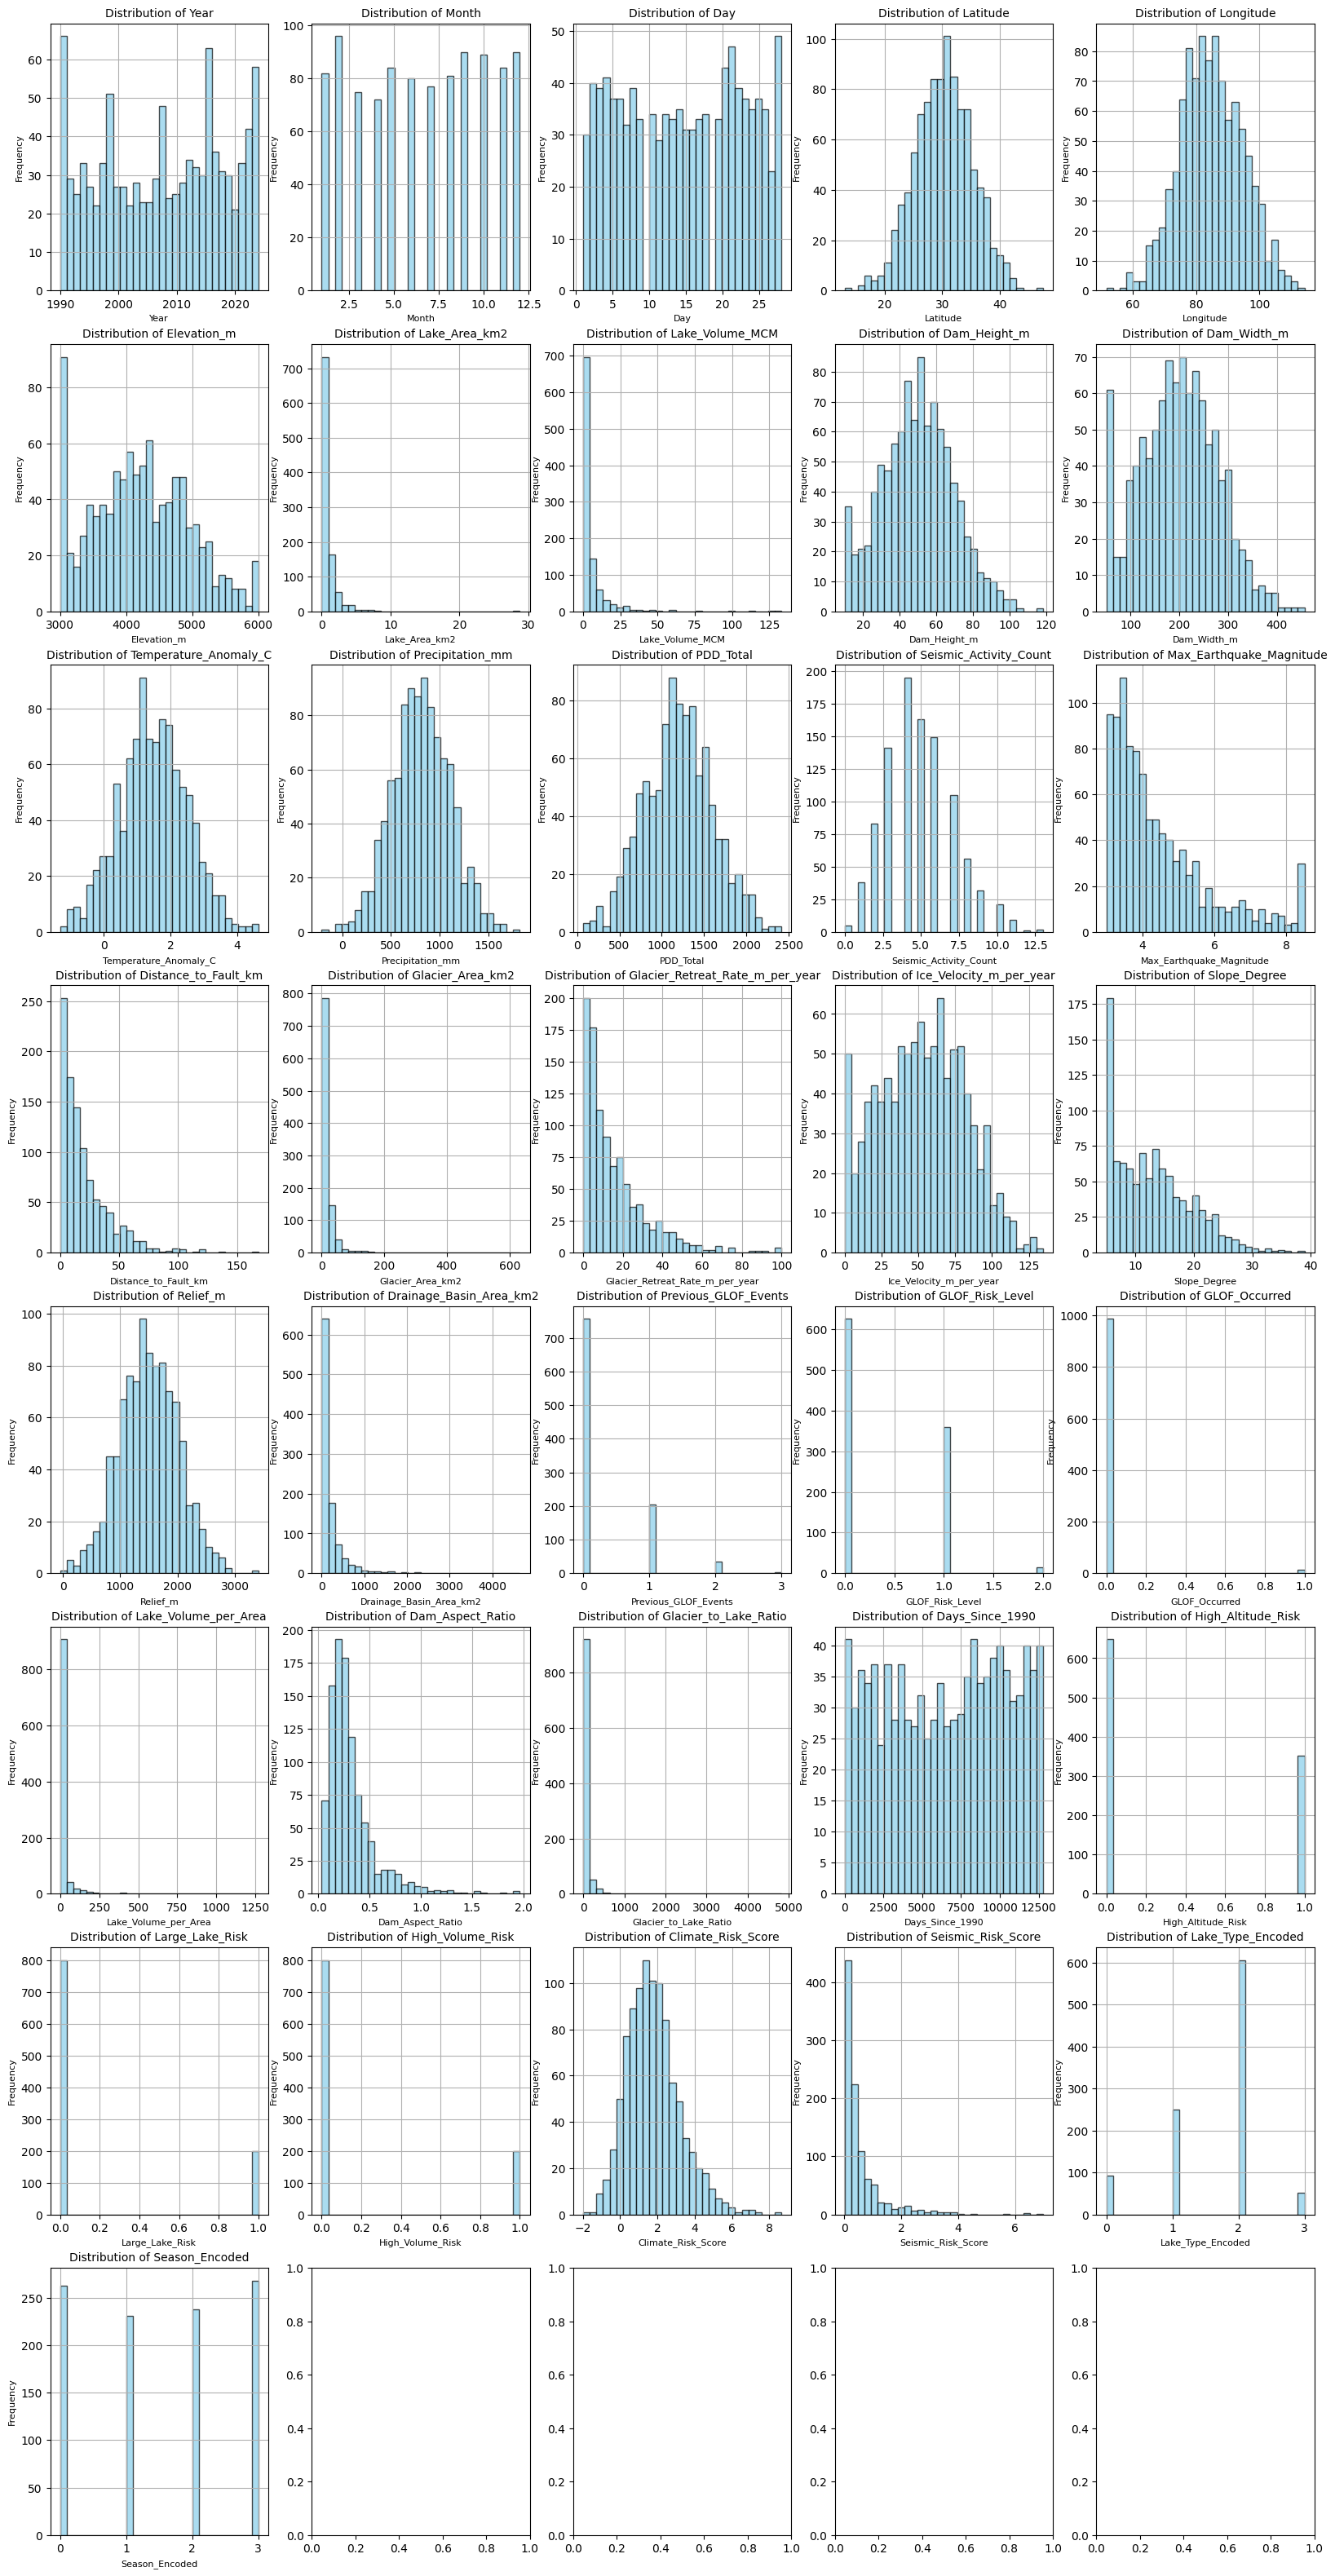

In [18]:
n_cols = 5
n_rows = (len(numerical_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(20, 5*n_rows))
axes = axes.flatten() if n_rows > 1 else [axes]

for i, col in enumerate(numerical_cols[:min(len(axes), len(numerical_cols))]):
    df[col].hist(bins=30, ax=axes[i], alpha=0.7, color='skyblue', edgecolor='black')
    axes[i].set_title(f"Distribution of {col}", fontsize=10)
    axes[i].set_xlabel(col, fontsize=8)
    axes[i].set_ylabel('Frequency', fontsize=8)

In [19]:
for j in range(len(numerical_cols), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig('univariate_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>


=== BIVARIATE ANALYSIS ===


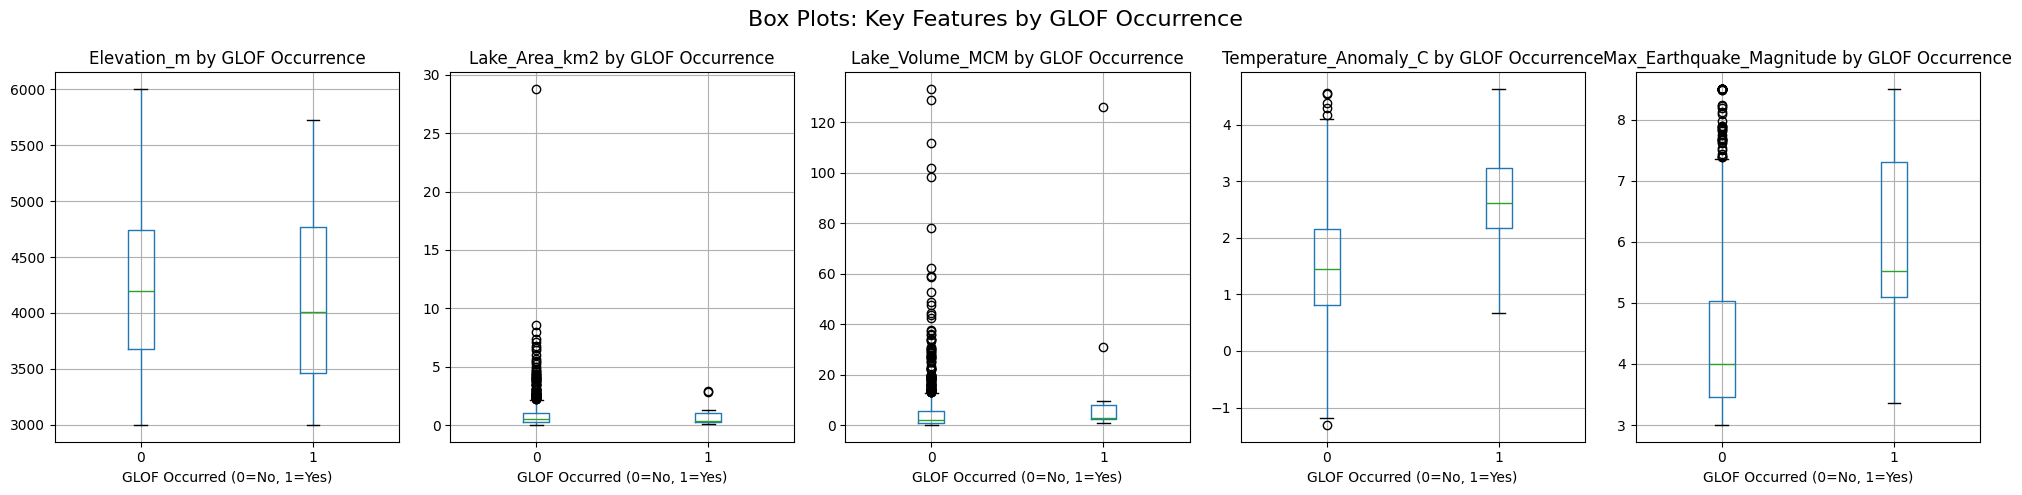

In [ ]:
key_features = ['Elevation_m', 'Lake_Area_km2', 'Lake_Volume_MCM', 'Temperature_Anomaly_C', 'Max_Earthquake_Magnitude']
fig, axes = plt.subplots(1, len(key_features), figsize=(20, 5))
for i, feature in enumerate(key_features):
    df.boxplot(column=feature, by='GLOF_Occurred', ax=axes[i])
    axes[i].set_title(f'{feature} by GLOF Occurrence')
    axes[i].set_xlabel('GLOF Occurred (0=No, 1=Yes)')

plt.suptitle('Box Plots: Key Features by GLOF Occurrence', fontsize=16)
plt.tight_layout()
plt.savefig('boxplots_glof_occurred.png', dpi=300, bbox_inches='tight')
plt.show()

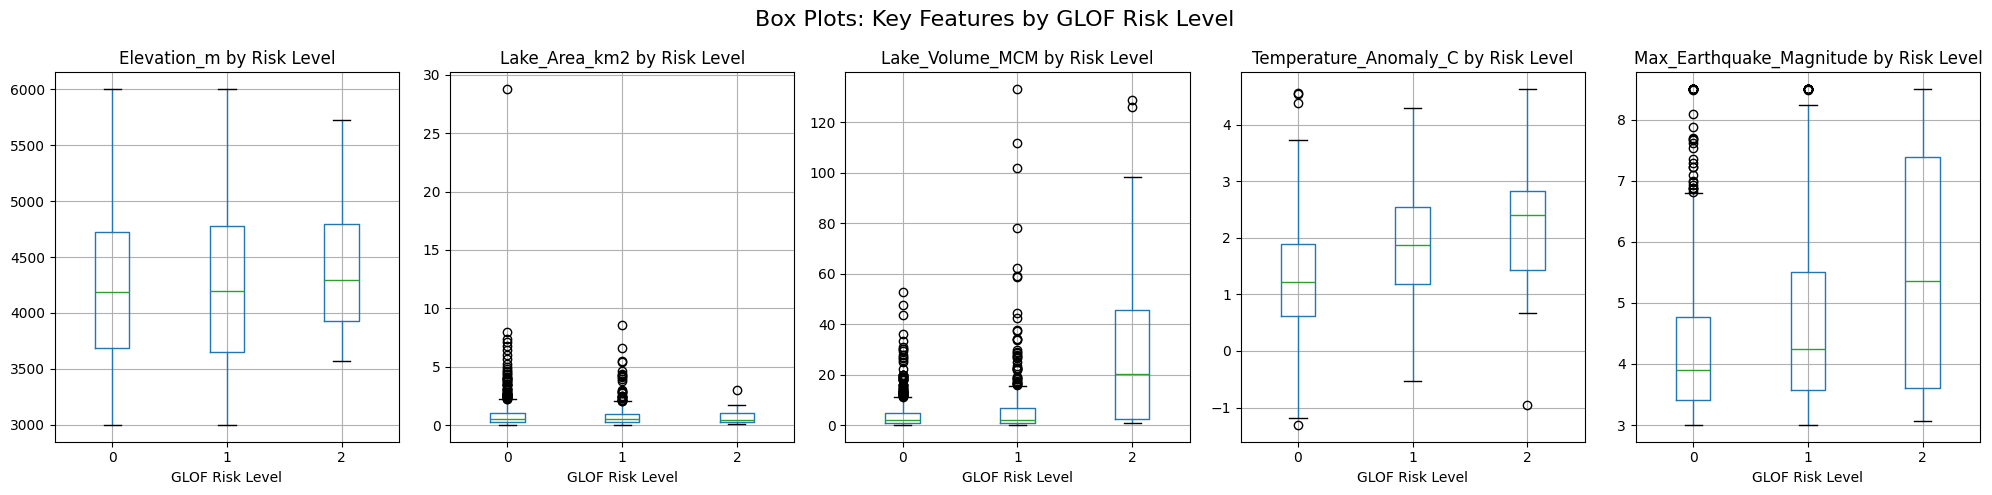

In [22]:
fig, axes = plt.subplots(1, len(key_features), figsize=(20, 5))
for i, feature in enumerate(key_features):
    df.boxplot(column=feature, by='GLOF_Risk_Level', ax=axes[i])
    axes[i].set_title(f'{feature} by Risk Level')
    axes[i].set_xlabel('GLOF Risk Level')

plt.suptitle('Box Plots: Key Features by GLOF Risk Level', fontsize=16)
plt.tight_layout()
plt.savefig('boxplots_risk_level.png', dpi=300, bbox_inches='tight')
plt.show()

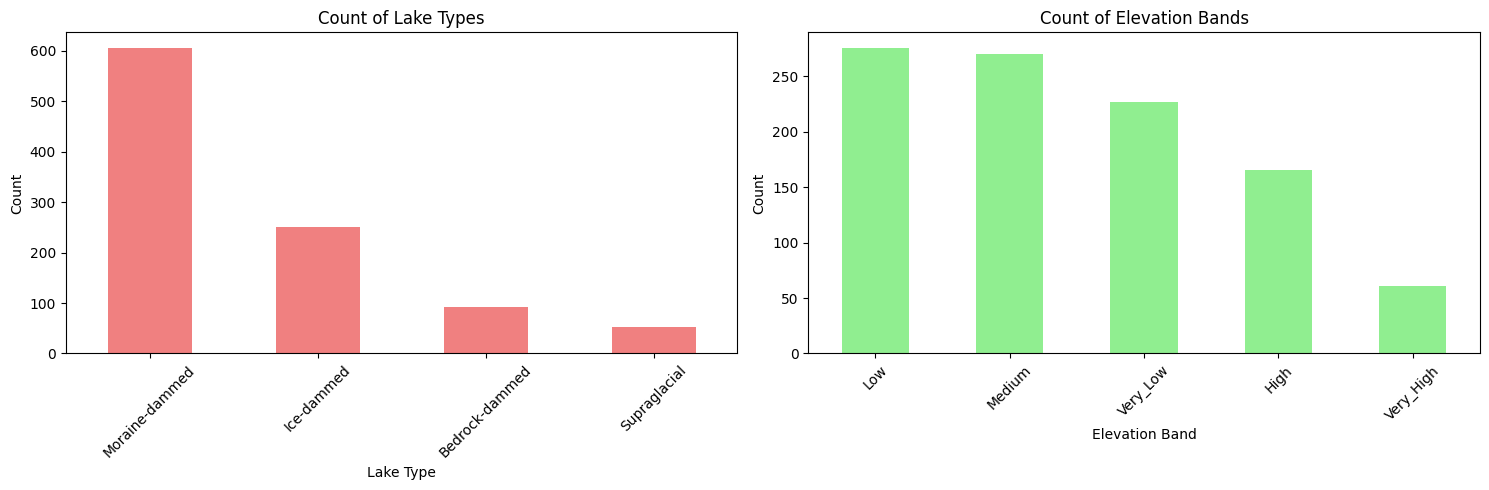

In [23]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
df_raw['Lake_Type'].value_counts().plot(kind='bar', ax=axes[0], color='lightcoral')
axes[0].set_title('Count of Lake Types')
axes[0].set_xlabel('Lake Type')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=45)

df_raw['Elevation_Band'].value_counts().plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Count of Elevation Bands')
axes[1].set_xlabel('Elevation Band')
axes[1].set_ylabel('Count')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('categorical_counts.png', dpi=300, bbox_inches='tight')
plt.show()


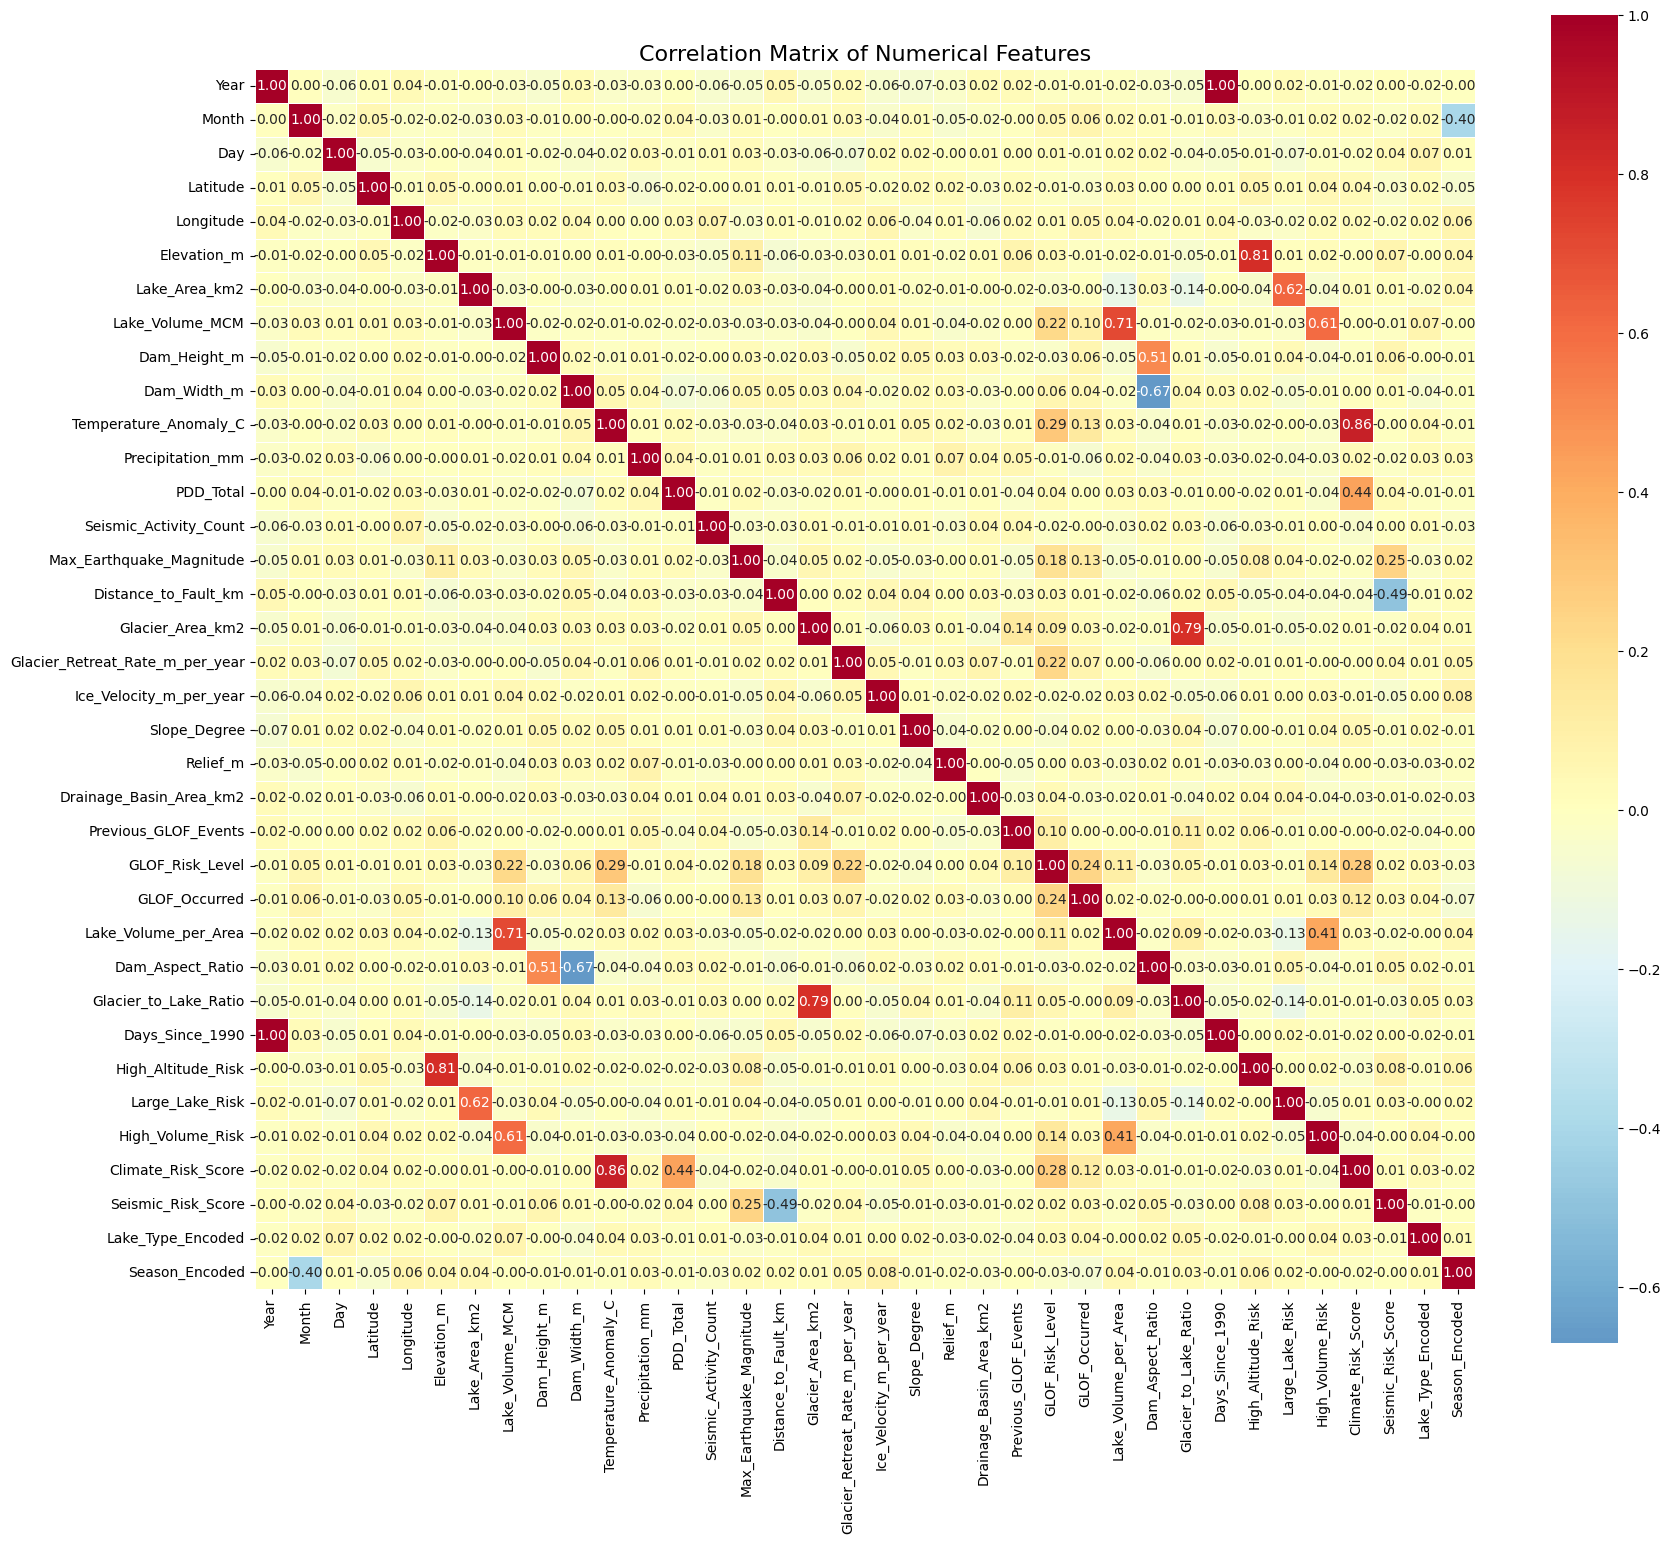

In [33]:
correlation_features = [col for col in numerical_cols if col in df.columns]
corr_matrix = df[correlation_features].corr()

plt.figure(figsize=(18, 18))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='RdYlBu_r', center=0,
            square=True, linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix of Numerical Features', fontsize=16)
plt.tight_layout()
plt.savefig('correlation_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 1500x1200 with 0 Axes>

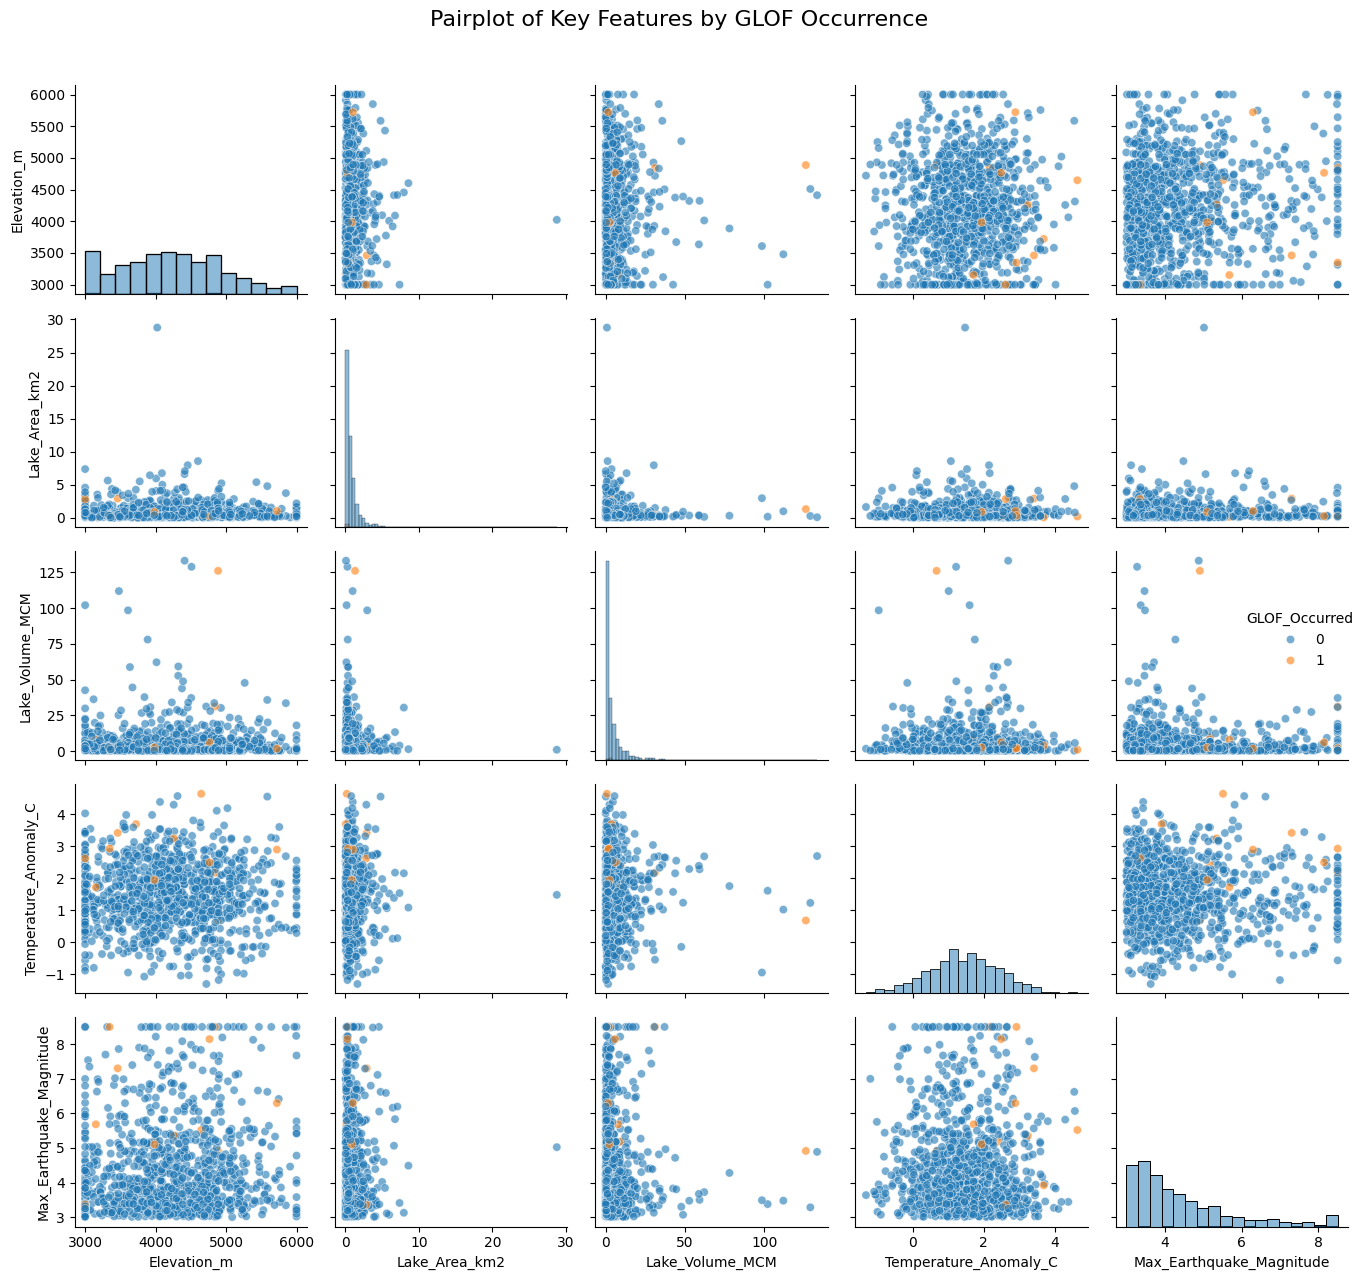

In [25]:
selected_for_pairplot = ['Elevation_m', 'Lake_Area_km2', 'Lake_Volume_MCM', 
                         'Temperature_Anomaly_C', 'Max_Earthquake_Magnitude', 'GLOF_Occurred']
pairplot_data = df[selected_for_pairplot].copy()
pairplot_data['GLOF_Occurred'] = pairplot_data['GLOF_Occurred'].astype('category')

plt.figure(figsize=(15, 12))
sns.pairplot(pairplot_data, hue='GLOF_Occurred', diag_kind='hist', plot_kws={'alpha': 0.6})
plt.suptitle('Pairplot of Key Features by GLOF Occurrence', y=1.02, fontsize=16)
plt.tight_layout()
plt.savefig('pairplot_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [27]:
features = [c for c in df.columns if c not in ['GLOF_Risk_Level','GLOF_Occurred']]
X = df[features]
y_risk = df['GLOF_Risk_Level']    # multi-class
y_occur = df['GLOF_Occurred']      # binary

print(f"\nFeatures for modeling: {len(features)} features")
print(f"Target distribution (GLOF_Occurred): {y_occur.value_counts().to_dict()}")
print(f"Target distribution (GLOF_Risk_Level): {y_risk.value_counts().to_dict()}")


Features for modeling: 34 features
Target distribution (GLOF_Occurred): {0: 987, 1: 13}
Target distribution (GLOF_Risk_Level): {0: 626, 1: 360, 2: 14}


In [28]:
X_train, X_test, y_r_train, y_r_test, y_o_train, y_o_test = \
    train_test_split(X, y_risk, y_occur, test_size=0.2, random_state=42, stratify=y_risk)

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'glof_scaler.pkl')
print("\nFeature scaling completed and scaler saved.")


Feature scaling completed and scaler saved.
